# Analysis Workflow

# Motivation
- Partial wave analysis can be complicated (fitting, bookkeeping, result handling, ...)
- PyAmpTools sacrifices flexibility for ease of use and focuses on Python as the core language
- **Features:**
    - Scientific Python ecosystem is massive (achieve most of the benefits of low level languages without the hassle)
    - Optimization uses gradients provided by JAX automatic differentiation (scales better than numerical diff.)
    - Hooks into several optimization frameworks spanning MLE, MCMC, to Variational Inference
        - iminuit, scipy, numpyro, iftpwa
    - YAML file is used to configure the analysis for consistency and automation
    - Fitting is generally done through the command line

# Example

This analysis chain is an example of an **input/output** study. 

1. We draw a sample from the nifty prior distribution
2. generate simulations (using `gen_amp` + `halld_sim/Piecewise` amplitude mimicking prior sample)
3. bin the data
4. fit the simulated data using:
    - Maximum Likelihood Estimation (MLE)
    - Markov Chain Monte Carlo (MCMC)
    - Information Field Theory (IFT)
5. plot the results

We would like to show a high probability of reconstruction. If this occurs for a wide variety of samples (and we believe our data could be approximately described by the very-flexible nifty prior) then we have successfully demonstrated that inference would be robust.

![alt text](optimization_mermaid.png)

In [1]:
import os
import subprocess
from pyamptools.utility.resultManager import ResultManager
from pyamptools.utility.resultManager import (
    plot_binned_intensities, 
    plot_binned_complex_plane, 
    plot_overview_across_bins, 
    plot_moments_across_bins, 
    montage_and_gif_select_plots
)
from IPython.display import IFrame
from pdf2image import convert_from_path

def run_command(command):
    """Captures output so we do not have to dump everything to the terminal"""
    result = subprocess.run(command, capture_output=True, shell=True, text=True)
    return result.stdout, result.stderr

def show_pdf(pdf_path, dpi=150):
    """
    Show a PDF in the notebook cell, rasterized since vscode jupyter cannot render PDFs
    
    """
    img = convert_from_path(pdf_path, dpi=dpi)[0]
    display(img)

PYAMPTOOLS_HOME = os.getenv("PYAMPTOOLS_HOME")
result_dir = f"{PYAMPTOOLS_HOME}/demos/ift_example/"

In [2]:
main_yaml = "main.yaml"

stdout, stderr = run_command(f"pa from_default -o {main_yaml}")

# Print contents of yaml file


In [9]:
from rich.console import Console
from rich.syntax import Syntax

with open(main_yaml, 'r') as f:
    yaml_content = f.read()

console = Console()
console.print(Syntax(yaml_content, "yaml", theme='default'))

## Drawing Simulations

Draw a sample from the iftpwa prior model then simulate data from the model and phase space MC. Then divide the data into kinematic bins. 

In [3]:
seed = 42
t_slope = 3.0
min_ebeam = 8.2
max_ebeam = 8.8
n_data = 10000
n_ps = 50000
stdout, stderr = run_command(f"pa run_priorSim {main_yaml} -s {seed} -emin {min_ebeam} -emax {max_ebeam} -t {t_slope} -nd {n_data} -np {n_ps}")

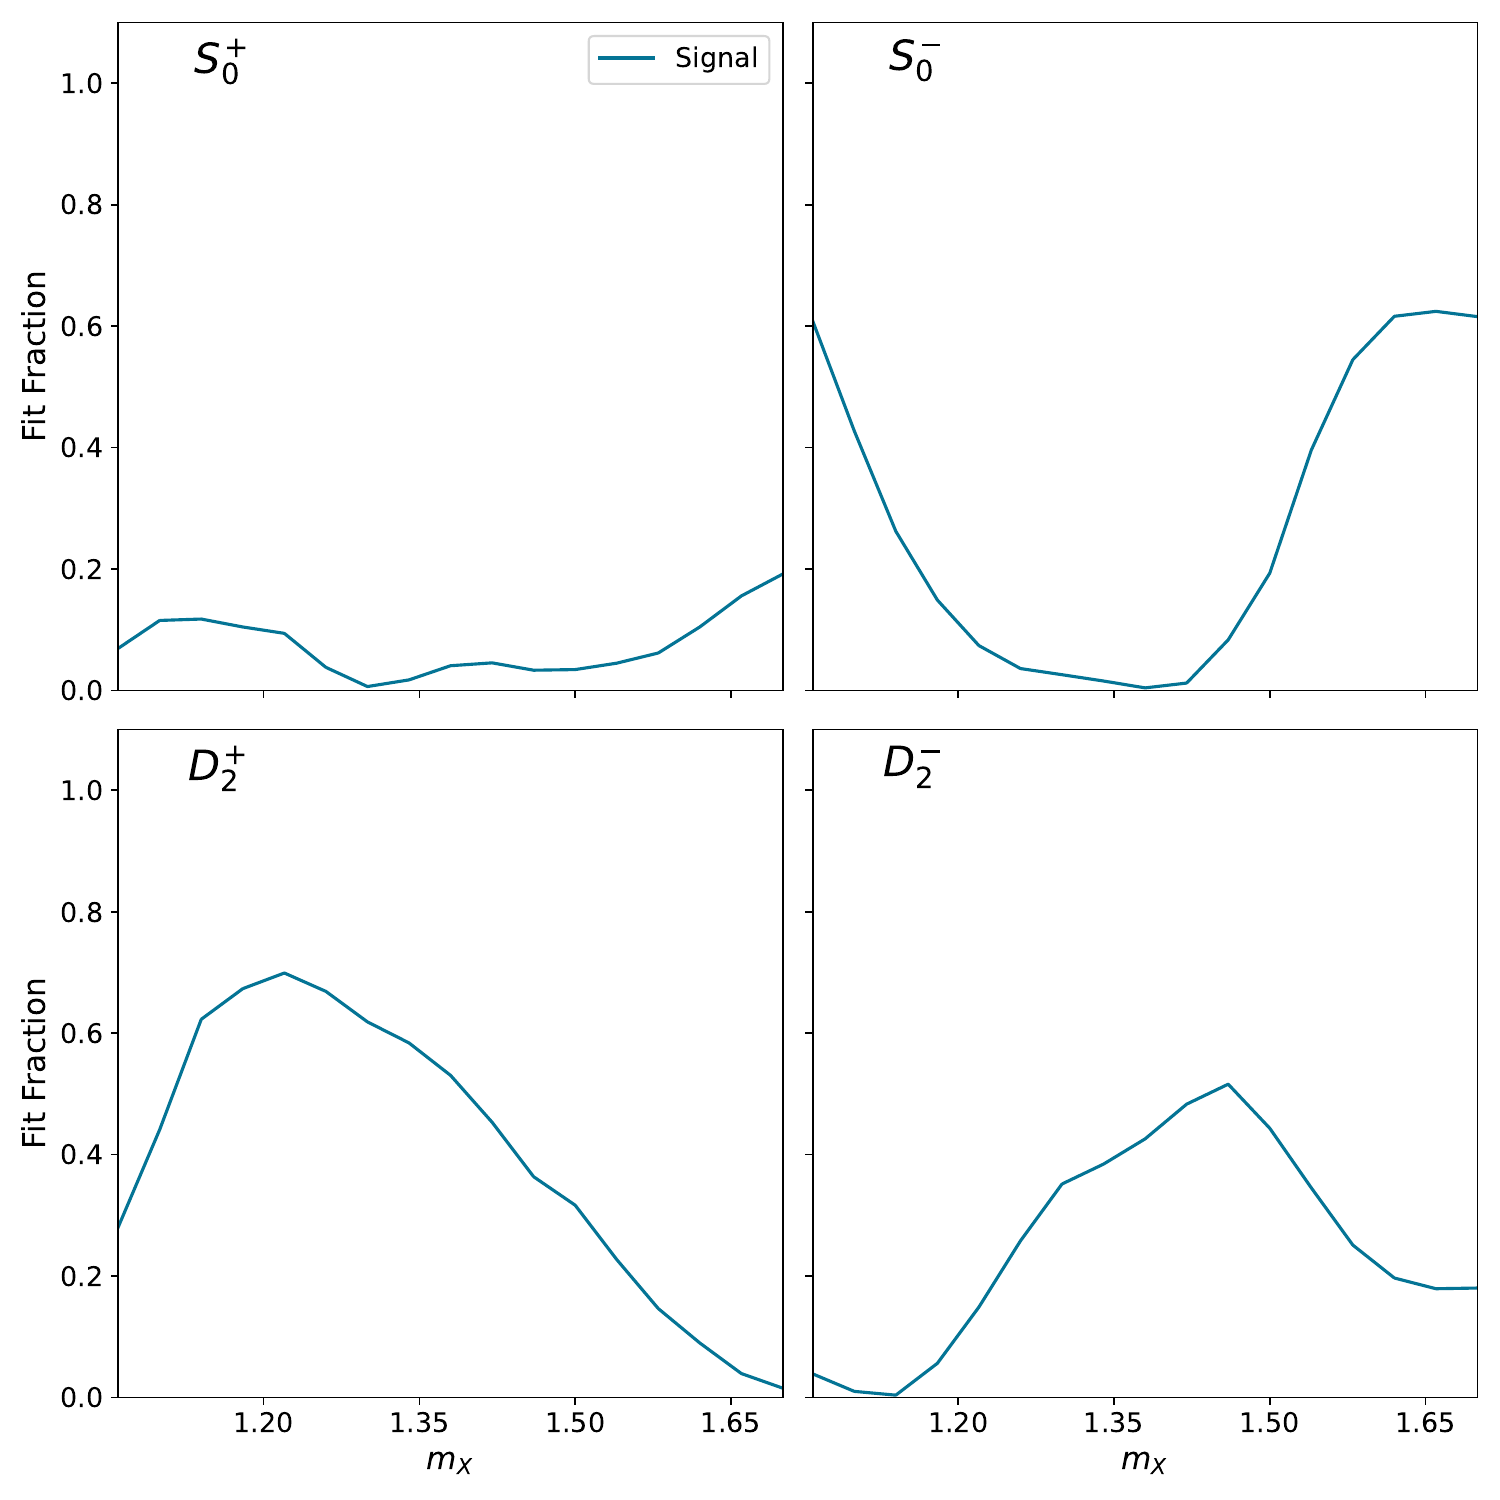

In [4]:
show_pdf("RESULTS/PLOTS/gen_curves.pdf")

## Run the MLE fits using iminuit

We begin by running a set of maximum likelihood fits on the generated data and compare the results to the generated amplitudes. The **ResultManager** class, when initialized with the path to the YAML file, will automatically attempt to load all results into memory. Each result (from MLE, MCMC, IFT) is stored a separate directory for unique access. All results (complex amplitude values, intensities, and metadata like mass, likelihood, etc.) are pulled into a flat pandas dataframe for efficient plotting and analysis.

The main "money" plot (intensity and relative phases of all partial waves) can be generated with the default plotting function, **plot_overview_across_bins**. The MLE results a slightly jittered to avoid too much overlap. The **dashed lines** are the generated amplitudes

In [5]:
stdout, stderr = run_command(f"pa run_mle {main_yaml}")

/w/halld-scshelf2101/lng/WORK/PyAmpTools9/src/pyamptools/utility/resultManager.py:441: RuntimeWarning: invalid value encountered in sqrt
  relative_phase_error = np.sqrt(variance) * 180.0 / np.pi
/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/site-packages/nifty8/library/correlated_fields.py:460: UserWarning: unable to add JAX operator for total_N=8
  warn(f"unable to add JAX operator for total_N={total_N}")


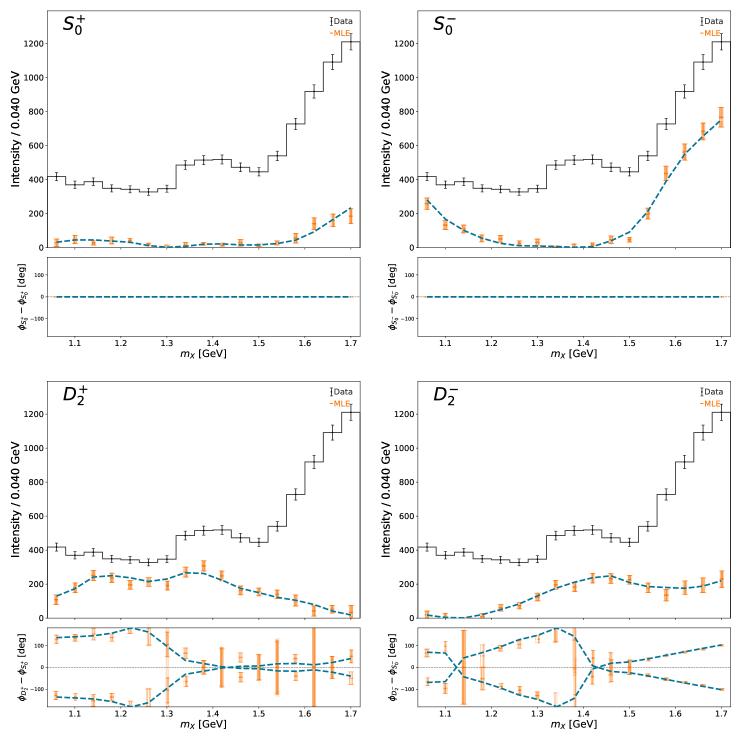

In [6]:
resultManager = ResultManager(main_yaml, silence=True) # Silence all the helpful output for clean documentation
resultManager.attempt_load_all()
plot_overview_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
show_pdf("RESULTS/PLOTS/intensity_and_phases/montage_output.pdf")
del resultManager

## Run MCMC fits using NUTS algorithm

MCMC is a set of techniques that draws samples from the posterior distribution. This framework uses Hamiltonian Monte Carlo (HMC) implemented in the No U-Turn Sampler (NUTS) algorithm. For this study, we choose 8 independent chains (each starting off in a different region of parameter space, traverses and draws samples from the posterior). **n_warmup** designates the number of samples to discard as the chains move toward a posterior mode and is used to adapt internal NUTS parameters. **n_samples** is the number of samples to draw for each chain. **n_chains** is drawn for each mass bin independently and the work is pooled across all **n_processes** processes.

The newly created MCMC results is automatically loaded by the **ResultManager** class and the same plotting calls are made

In [7]:
n_processes = 17
n_chains = 8
n_warmup = 500
n_samples = 1000
stdout, stderr = run_command(f"pa run_mcmc {main_yaml} -np {n_processes} -nc {n_chains} -nw {n_warmup} -ns {n_samples}")

/w/halld-scshelf2101/lng/WORK/PyAmpTools9/src/pyamptools/utility/resultManager.py:441: RuntimeWarning: invalid value encountered in sqrt
  relative_phase_error = np.sqrt(variance) * 180.0 / np.pi
/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/site-packages/nifty8/library/correlated_fields.py:460: UserWarning: unable to add JAX operator for total_N=8
  warn(f"unable to add JAX operator for total_N={total_N}")


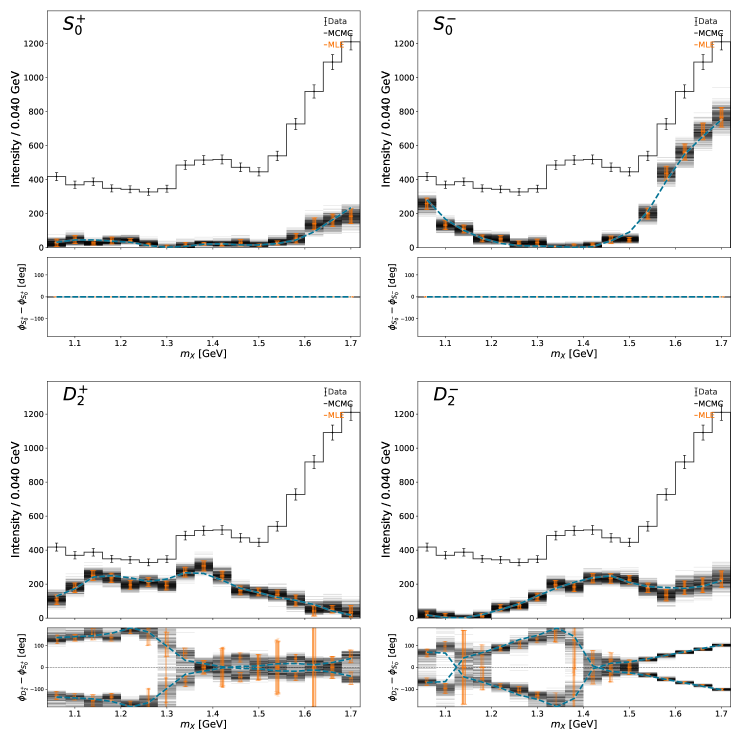

In [8]:
resultManager = ResultManager(main_yaml, silence=True)
resultManager.attempt_load_all()
plot_overview_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
show_pdf("RESULTS/PLOTS/intensity_and_phases/montage_output.pdf")
del resultManager

## Run `iftpwa` fit

Finally we run a IFT analysis with the same prior model used to generate the synthetic data to obtain a posterior estimate. These are shown in the **solid lines**

In [9]:
stdout, stderr = run_command(f"pa run_ift {main_yaml}")

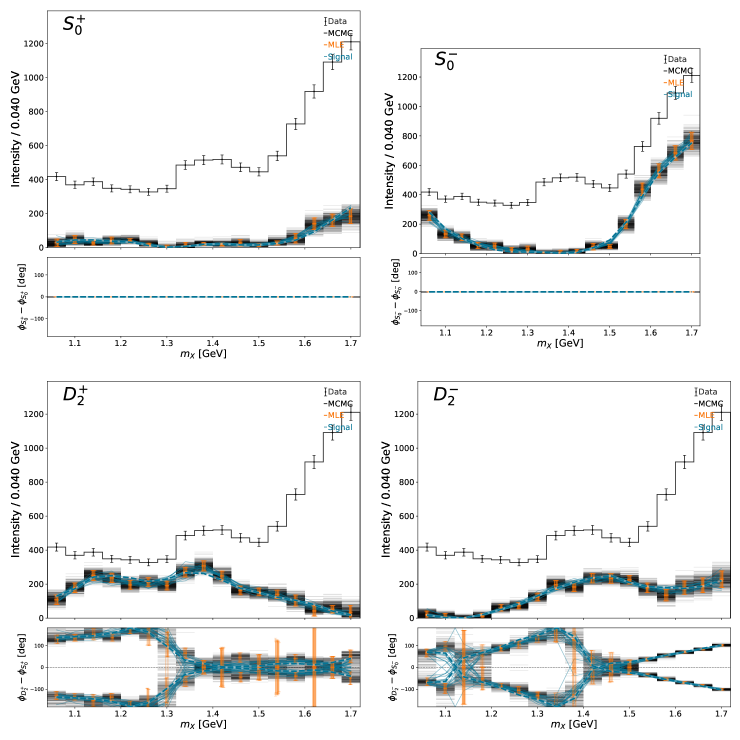

In [12]:
resultManager = ResultManager(main_yaml, silence=True)
resultManager.attempt_load_all()
plot_overview_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
show_pdf("RESULTS/PLOTS/intensity_and_phases/montage_output.pdf")

# Additional Plots

This sections contains a few additional default plots that highlight different aspects of the analysis: 
1. Plot projected moments
2. Plot inferred amplitudes in the complex plane
3. Plot intensity distributions

We first need to create the plots which also requires projecting the amplitudes onto the moment basis.

In [17]:
from pyamptools.utility.resultManager import plot_binned_complex_plane, plot_binned_intensities, plot_moments_across_bins

resultManager = ResultManager(main_yaml, silence=True)
resultManager.attempt_load_all()
resultManager.attempt_project_moments(normalization_scheme=0, pool_size=4, silence=True)
plot_binned_complex_plane(resultManager, file_type='pdf', silence=True)
plot_binned_intensities(resultManager, file_type='pdf', silence=True)
plot_moments_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
del resultManager

/w/halld-scshelf2101/lng/WORK/PyAmpTools9/src/pyamptools/utility/resultManager.py:441: RuntimeWarning: invalid value encountered in sqrt
  relative_phase_error = np.sqrt(variance) * 180.0 / np.pi
/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/site-packages/nifty8/library/correlated_fields.py:460: UserWarning: unable to add JAX operator for total_N=8
  warn(f"unable to add JAX operator for total_N={total_N}")
/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/site-packages/nifty8/library/correlated_fields.py:460: UserWarning: unable to add JAX operator for total_N=8
  warn(f"unable to add JAX operator for total_N={total_N}")


MomentManagerTwoPS| Calculating moments assuming a TwoPseudoscalar system with max J = 4


/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Calculating TwoPS moments in batches of 100: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


MomentManagerTwoPS| Calculating moments assuming a TwoPseudoscalar system with max J = 4


/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Calculating TwoPS moments in batches of 100: 100%|██████████| 1360/1360 [01:26<00:00, 15.67it/s]/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



MomentManagerTwoPS| Calculating moments assuming a TwoPseudoscalar system with max J = 4


/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Calculating TwoPS moments in batches of 100: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


MomentManagerTwoPS| Calculating moments assuming a TwoPseudoscalar system with max J = 4


/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


## Plot projected moments

We can project the inferred amplitudes into moments to understand whether the scatter in the amplitude basis collapses onto a tighter space in the moment basis. This allows one to answer questions related to ambiguities and stability of the inference in the amplitude basis. 

Here, we only plot the non-zero moments (given the set of inferred partial waves). The moments are normalized to the zeroth moment. The MLE point estimates are only shown (errors not propagated)

In [ ]:
show_pdf("RESULTS/PLOTS/moments/montage_output.pdf")

## Plots of the complex plane:

The inferred amplitudes live in the complex plane. We can scatter the inferred amplitudes and compare the results from the different techniques to see how they compare. A comparison is only shown for one bin. The reference waves are shown as histograms since they have no imaginary component. The color of the scattered points in the non-reference waves is mapped to the intensity of the corresponding reference wave. In this example, the MLE and MCMC results agree and that the MLE errors track the MCMC samples. The band of MCMC solutions is from the smaller reference wave intensity not locking in a well defined phase

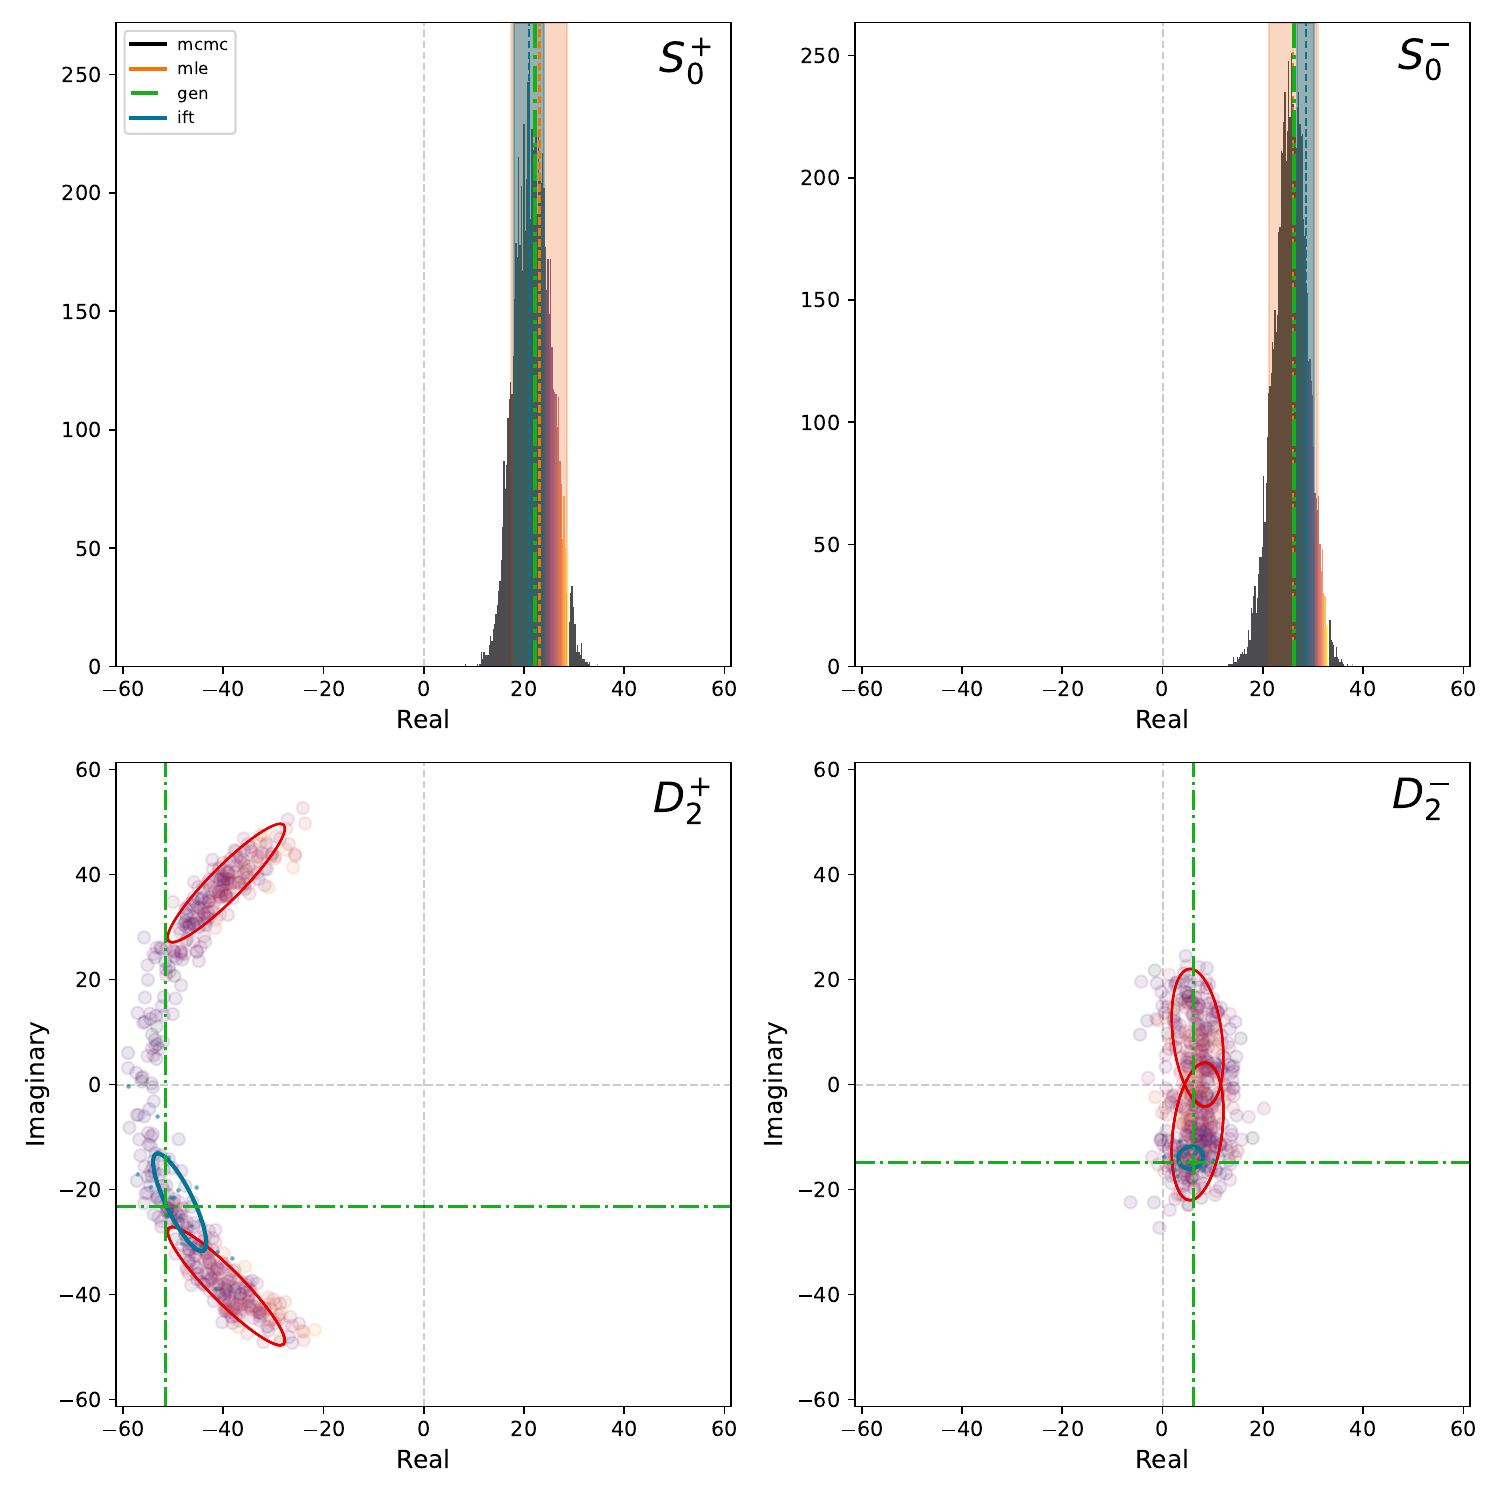

In [23]:
show_pdf("RESULTS/PLOTS/complex_plane/bin3_complex_plane.pdf")

## Plots of the intensity distributions:

The overview plot (intensity and relative phases as a function of mass) gives a qualitative description of the results. This plot shows the distribution of results from the various techniques in a single bin. The $D_2^-$ wave in this bin is small. The estimated MLE uncertainties are bad in this case and covers negative values. The MCMC results shows a highly skewed distribution. 


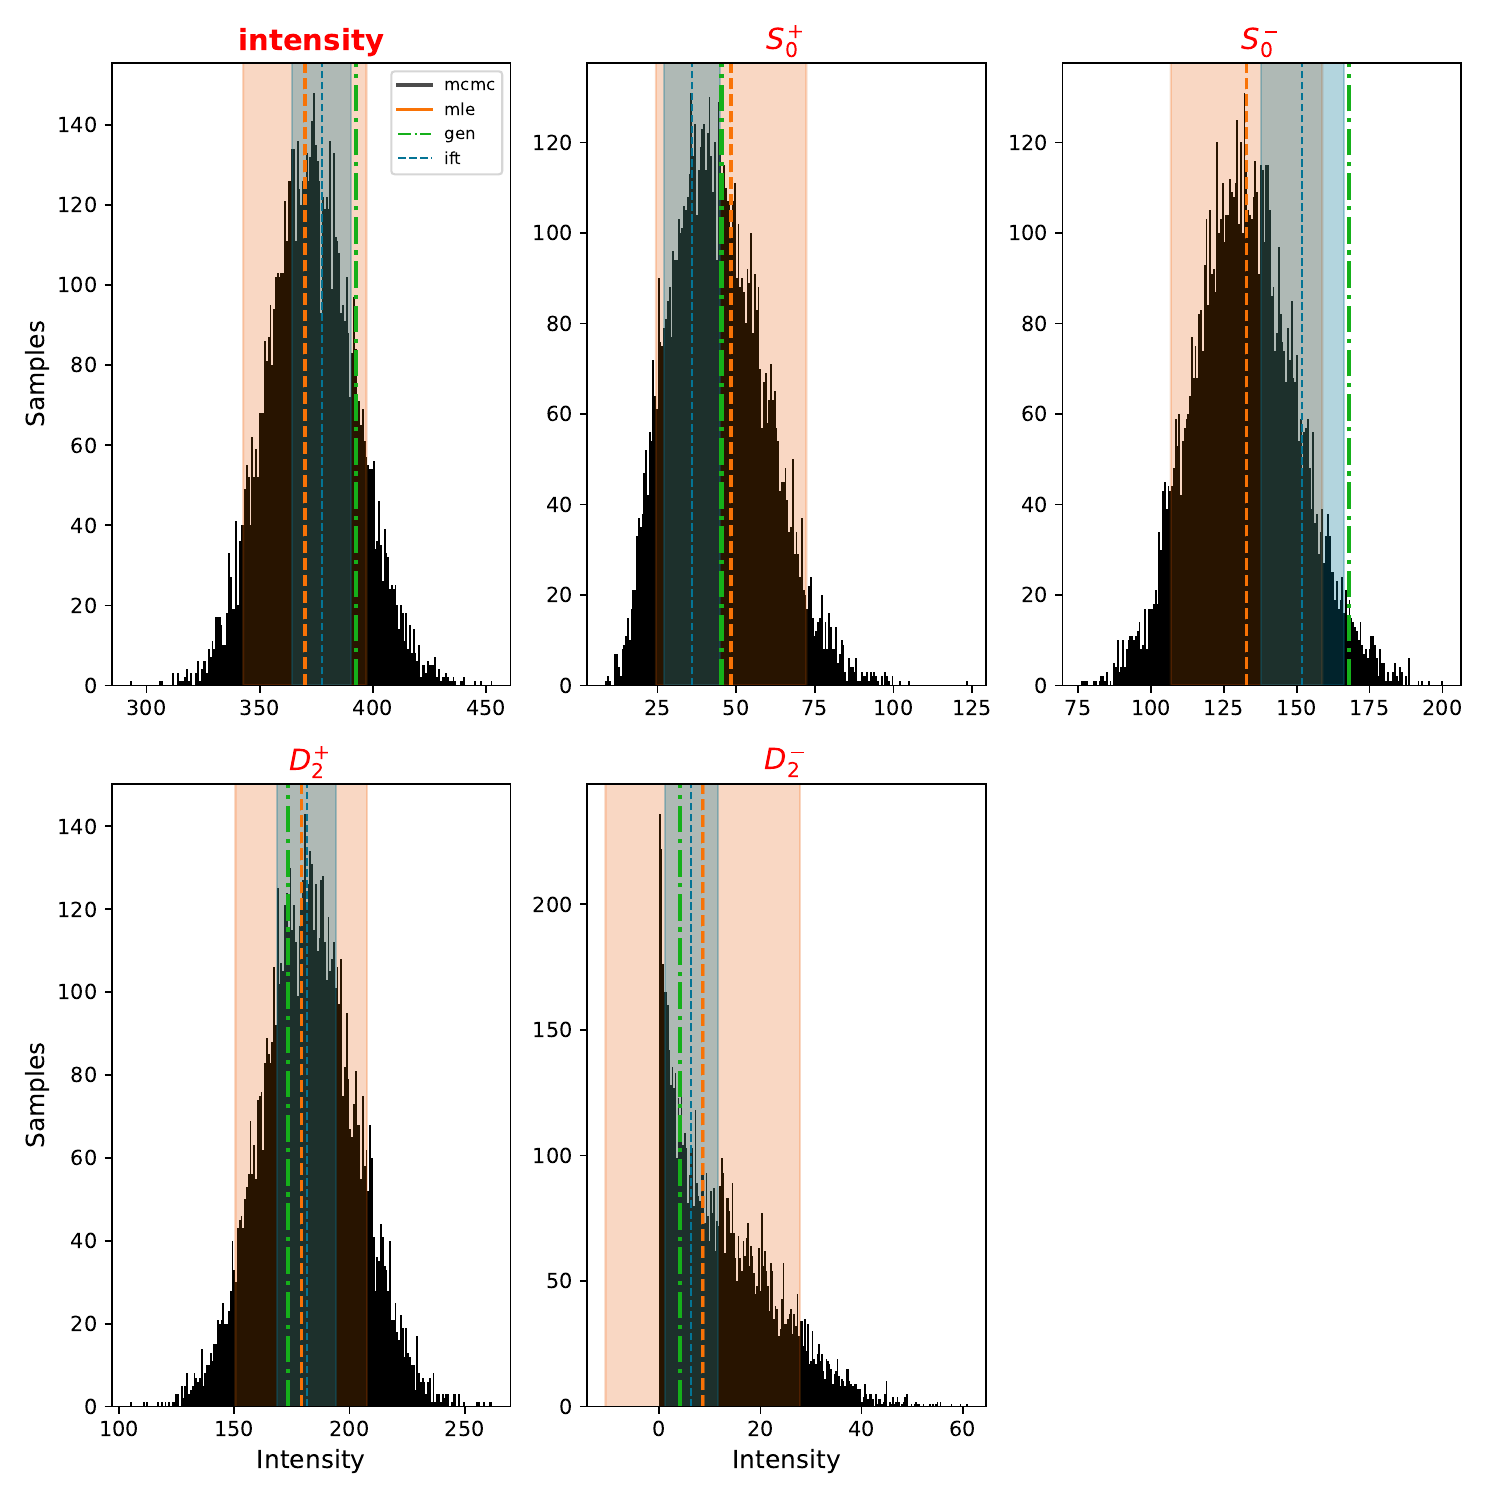

In [25]:
show_pdf("RESULTS/PLOTS/intensity/bin1_intensities.pdf")

# Cleanup

In [20]:
os.system(f'rm -rf main.yaml local_beam.conf *.lock')
os.system(f'rm -r RESULTS')

0